<h1>Import the required libraries</h1>

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

<h1>Implement KD-tree</h1>

In [2]:
class KD_Node:
    def __init__(self, hyperplane=None, constant=None, values=None, indices=None):
        self.hyperplane = hyperplane
        self.constant = constant
        self.values = values
        self.indices = indices
        self.left = None
        self.right = None


class KD_tree:
    def __init__(self, k):
        self.k = k
        self.tree = None

    @staticmethod
    def __between_finder(record1, record2):
        normal_vector = record2 - record1
        midpoint = (record1 + record2) / 2
        const_term = np.dot(normal_vector, midpoint)
        return normal_vector, const_term

    @staticmethod
    def __record_side_checker(normal_vector, const, vector):
        result = np.dot(normal_vector, vector)
        if result < const:
            return "right"
        return "left"

    def __build_tree(self, vectors, indices):
        idx1 = 0
        idx2 = 0
        while idx1==idx2:
            idx1 = random.randint(0,len(vectors)-1)
            idx2 = random.randint(0,len(vectors)-1)
         
        first_vector = vectors[idx1]
        second_vector = vectors[idx2]
        
        hyperplane,constant = self.__between_finder(first_vector,second_vector)
        left_nodes=[]
        right_nodes=[]
        left_indices, right_indices = [], []

        for vector, index in zip(vectors, indices):
            side = self.__record_side_checker(hyperplane, constant, vector)
            if side == "right":
                right_nodes.append(vector)
                right_indices.append(index)
            else:
                left_nodes.append(vector)
                left_indices.append(index)

        current_node = KD_Node(hyperplane=hyperplane,constant=constant,values=vectors, indices=indices)
        

        if len(left_nodes) > self.k:
            current_node.left = self.__build_tree(left_nodes, left_indices)
        else:
            current_node.left = KD_Node(values=left_nodes,indices=left_indices)

        if len(right_nodes) > self.k:
            current_node.right = self.__build_tree(right_nodes, right_indices)
        else:
            current_node.right = KD_Node(values=right_nodes, indices=right_indices)

        return current_node


    def to_tree(self, x_train):
        indices = list(range(len(x_train)))
        self.tree = self.__build_tree(x_train, indices)
        return self.tree

    def get_neighbors(self, query_vector):
        tree = self.tree
        while len(tree.indices) > self.k and tree.hyperplane is not None and tree.constant is not None:
            side = self.__record_side_checker(tree.hyperplane,tree.constant,query_vector)
            if side=="left":  
                tree = tree.left
            elif side=="right":
                tree = tree.right
        return tree.indices

<h1>Implement Ball-tree</h1>

In [3]:
class BallTreeNode:
    def __init__(self, values=None, labels=None, depth=0):
        self.center = np.mean(values, axis=0)
        self.radius = np.max(np.linalg.norm(values - self.center, axis=1))
        self.values = values
        self.labels = labels
        self.depth = depth
        self.left = None
        self.right = None
        self.is_leaf = False

class BallTree:
    def __init__(self, leaf_size=40):
        self.leaf_size = leaf_size
        self.root = None
    
    def to_tree(self, X_train, y_train):
        if len(X_train) == 0:
            return None
        self.root = self.__build_tree(X_train, y_train, depth=0)
    
    def __build_tree(self, values, labels, depth):
        num_of_samples = len(values)
        if num_of_samples <= self.leaf_size:
            node = BallTreeNode(values=values, labels=labels, depth=depth)
            node.is_leaf = True
            return node

        max_dim = np.max(values, axis=0) - np.min(values, axis=0)
        split_dim = np.argmax(max_dim)

        indices = np.argsort(values[:, split_dim])
        values = values[indices]
        labels = labels[indices]
        
        median_idx = num_of_samples // 2
        left_values = values[:median_idx]
        left_labels = labels[:median_idx]
        right_values = values[median_idx:]
        right_labels = labels[median_idx:]

        node = BallTreeNode(values, labels, depth)
        node.left = self.__build_tree(left_values, left_labels, depth+1)
        node.right = self.__build_tree(right_values, right_labels, depth+1)

        return node
    
    def query(self, X_test, k):
        if self.root is None:
            raise ValueError("Tree is not built yet!")
        
        self.best_distances = np.full(k, np.inf)
        self.best_labels = [None] * k
        self.__query_rec(self.root, X_test, k)

        indices = np.argsort(self.best_distances)
        return self.best_distances[indices], np.array(self.best_labels)[indices]

    def __query_rec(self, node, X_test, k):
        dist_to_center = np.linalg.norm(X_test - node.center)

        if node.is_leaf:
            distances = np.linalg.norm(node.values - X_test, axis=1)
            for i, dist in enumerate(distances):
                if dist < self.best_distances[-1]:
                    insert_idx = np.searchsorted(self.best_distances, dist)
                    self.best_distances[insert_idx+1:] = self.best_distances[insert_idx:-1]
                    self.best_labels[insert_idx+1:] = self.best_labels[insert_idx:-1]
                    self.best_distances[insert_idx] = dist
                    self.best_labels[insert_idx] = node.labels[i]
            return
        if dist_to_center - node.radius > self.best_distances[-1]:
            return
        
        left_dist = np.linalg.norm(X_test - node.left.center) if node.left else np.inf
        right_dist = np.linalg.norm(X_test - node.right.center) if node.right else np.inf
        
        if left_dist < right_dist:
            self.__query_rec(node.left, X_test, k)
            self.__query_rec(node.right, X_test, k)
        else:
            self.__query_rec(node.right, X_test, k)
            self.__query_rec(node.left, X_test, k)



class BallTreeKNN:
    def __init__(self, k=3, leaf_size=20):
        self.k = k
        self.tree = BallTree(leaf_size)
        self.classes = None
    
    def fit(self, X, y):
        self.tree.to_tree(np.array(X), np.array(y))
        self.classes = np.unique(y)
    
    def predict(self, X):
        X = np.array(X)
        if len(X.shape) == 1:
            X = X.reshape(1, -1)
            
        predictions = [self._predict_single(x) for x in tqdm(X)]

        return np.array(predictions)
    
    def _predict_single(self, x):
        distances, labels = self.tree.query(x, self.k)
        vote = Counter(labels).most_common(1)[0][0]
        return vote

<h1>Implement KNN</h1>

In [4]:
class KNearestNeighbors:
    def __init__(self, k, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric.lower()
        self.distance_functions = {
            'euclidean': self.__euclidean_distance,
        }
        if self.distance_metric not in self.distance_functions:
            raise ValueError(f"Unsupported distance metric: {self.distance_metric}")
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def __euclidean_distance(self, record1, record2):
        return np.sqrt(np.sum((record1 - record2) ** 2))
    
    def __distance(self, record1, record2):
        return self.distance_functions[self.distance_metric](record1, record2)
    
    def __neighbors_finder(self, x_test):
        # x_test is a record for test
        distance_cache = [(i, self.__distance(x_test, x_train)) for i, x_train in enumerate(self.X_train)]
        distance_cache.sort(key=lambda x:x[1])
        return [i for i, dist in distance_cache[:self.k]]
    
    
    def predict(self, X_test):
        predictions = []
        for x_test in tqdm(X_test):
            k_neighbors_indices = self.__neighbors_finder(x_test)
            k_neighbors_labels = self.y_train[k_neighbors_indices]
            unique, counts = np.unique(k_neighbors_labels, return_counts=True)
            most_common = unique[np.argmax(counts)]
            predictions.append(most_common)

        return np.array(predictions)


<h1>Load Dataset : MNIST</h1>

In [5]:
df_train = pd.read_csv("/kaggle/input/mnist-in-csv/mnist_train.csv")

In [6]:
X_train = df_train.iloc[:, 1:].values
y_train = df_train.iloc[:, 0].values

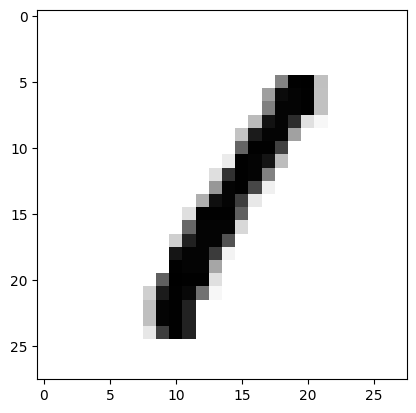

In [7]:
plt.imshow((X_train[3].reshape(28,28)), cmap=plt.cm.gray_r)

In [8]:
X_train = X_train / 255.0

In [9]:
df_test = pd.read_csv("/kaggle/input/mnist-in-csv/mnist_test.csv")

In [10]:
X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

In [11]:
X_test = X_test / 255.0

<h1>Try KNN</h1>

In [12]:
model = KNearestNeighbors(k=11)
model.fit(X_train, y_train)

In [13]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

100%|██████████| 10000/10000 [2:03:59<00:00,  1.34it/s] 

Accuracy: 0.9668


<h1>Try KD-Tree</h1>

In [15]:
import random
kdtree = KD_tree(k=5)
kdtree.to_tree(X_train)

In [18]:
def predict(tree, query_vectors, labels):
    predicts = []
    for query_vector in tqdm(query_vectors):
        neighbor_indices = tree.get_neighbors(query_vector)
        neighbor_labels = [labels[i] for i in neighbor_indices]  
        predicted_label = max(set(neighbor_labels), key=neighbor_labels.count)
        predicts.append(predicted_label)
    return np.array(predicts)

In [19]:
predict_digits = predict(kdtree, X_test, y_train)
print("Accuracy:", accuracy_score(y_test, predict_digits))

100%|██████████| 10000/10000 [00:00<00:00, 17356.84it/s]

Accuracy: 0.8018


<h1>Try Ball-Tree</h1>

In [20]:
k = 5
leaf_size = 10
bt = BallTreeKNN(k, leaf_size)
bt.fit(X_train, y_train)

In [21]:
predict_digits = bt.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predict_digits))

100%|██████████| 10000/10000 [1:25:11<00:00,  1.96it/s]

Accuracy: 0.9693


# 🔥 Comparison of KNN Methods on the MNIST Dataset 🔥

This section compares **three different methods for running KNN**:

| Method | Execution Time | Accuracy |
|--------|--------------|----------|
| **Brute-Force (Standard KNN)** | ⏳ 2 Hours and 4 minutes | ✅ 96.68% |
| **KD-Tree** | ⚡ Less than 1 second | ❌ 80.18% |
| **Ball Tree** | 🏆 1 Hour and 25 minutes | ✅ **96.93%** |

### 📌 **Conclusion**
1. **Brute-Force KNN** achieves high accuracy but is **extremely slow**.  
2. **KD-Tree** is very fast but **performs poorly on high-dimensional data**.  
3. **Ball Tree** provides a balance between **speed and accuracy**, making it the best choice for this dataset.  

🚀 **Ball Tree proved to be the best method for running KNN on MNIST without any extra preprocessing!**  
